In [1]:
import json
from pathlib import Path

import numpy as np
import torch

from torch.utils.data import (
    DataLoader, 
    WeightedRandomSampler
)

from tqdm.autonotebook import tqdm
from ezmsg.util.messagelogger import MessageDecoder

from hololight.shallowfbcspnet import ShallowFBCSPNet, FBCSPDataset, dummy_output

from typing import List


/Users/milsagw1/repos/git/hololight/env/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

samples = []
data_fname = Path( '..' ) / 'recordings' / 'traindata.txt'
with open( data_fname, 'r' ) as data_file:
    samples = [ json.loads( line, cls = MessageDecoder ) for line in data_file ]

eeg_trials = np.array( [ s[ 'sample' ][ 'data' ] for s in samples ] ).swapaxes( 1, 2 )
eeg_labels = np.array( [ s[ 'trigger' ][ 'value' ] for s in samples ] )

train_dset = FBCSPDataset( eeg_trials[:40, ...], eeg_labels[:40, ...] )
test_dset = FBCSPDataset( eeg_trials[40:, ...], eeg_labels[40:, ...] )

In [3]:
net = ShallowFBCSPNet(
    in_chans = eeg_trials.shape[1],
    n_classes = len( train_dset.class_map ),
    input_time_length = eeg_trials.shape[2],
    cropped_training = True,
    n_filters_time = 40,
    filter_time_length = 25,
    n_filters_spat = 40,
    pool_time_length = 75,
    pool_time_stride = 15,
    conv_nonlin = 'square',
    pool_mode = 'mean',
    pool_nonlin = 'safe_log',
    split_first_layer = True,
    batch_norm = True,
    batch_norm_alpha = 0.1,
    drop_prob = 0.5,
    device = 'cpu',
    single_precision = False
)

print( net.model )
print( net.optimal_temporal_stride )
print( dummy_output( net.model, net.in_chans, net.input_time_length ).shape )

Sequential(
  (ensuredims): Ensure4d()
  (dimshuffle): Expression(expression=_transpose_time_to_spat)
  (conv_time): Conv2d(1, 40, kernel_size=(25, 1), stride=(1, 1))
  (conv_spat): Conv2d(40, 40, kernel_size=(1, 8), stride=(1, 1), bias=False)
  (bnorm): BatchNorm2d(40, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv_nonlin): Expression(expression=square)
  (pool): AvgPool2d(kernel_size=(75, 1), stride=(1, 1), padding=0)
  (pool_nonlin): Expression(expression=safe_log)
  (drop): Dropout(p=0.5, inplace=False)
  (conv_classifier): Conv2d(40, 2, kernel_size=(30, 1), stride=(1, 1), dilation=(15, 1))
  (softmax): LogSoftmax(dim=1)
  (squeeze): Expression(expression=_squeeze_final_output)
)
467
torch.Size([1, 2, 467])


In [4]:
learning_rate = 0.0001
max_epochs = 30
batch_size = 32
weight_decay = 0.0

model_parameters = filter( lambda p: p.requires_grad, net.model.parameters() )
params = sum( [ np.prod( p.size() ) for p in model_parameters ] )
print( f'Model has {params} trainable parameters' )

loss_fn = torch.nn.NLLLoss()
optimizer = torch.optim.AdamW( 
    net.model.parameters(), 
    lr = learning_rate, 
    weight_decay = weight_decay 
)

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR( optimizer, T_max = max_epochs / 1 )

best_loss = None
best_loss_epoch = None

train_loss, test_loss, test_accuracy = [], [], []
lr = []

epoch_itr = tqdm( range( max_epochs ) )

# Calculate weights for class balancing
classes, counts = torch.unique( train_dset.y, return_counts = True )
weights = { cl.item(): 1.0 / co.item() for cl, co in zip( classes, counts ) }
weights = [ weights[ lab.item() ] for lab in train_dset.y ]

for epoch in epoch_itr:

    net.model.train()
    train_loss_batches = []
    for train_feats, train_labels in DataLoader(
        train_dset,
        batch_size = batch_size, 
        # drop_last = True,
        sampler = WeightedRandomSampler( weights, len( train_dset ), replacement = False ),
        pin_memory = True,
    ):
        pred = net.model( train_feats.to( net._device ) )
        if net.cropped_training:
            pred = pred.mean( axis = 2 )
        loss = loss_fn( pred, train_labels.to( net._device ) )
        train_loss_batches.append( loss.cpu().item() )

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    scheduler.step()

    lr.append( scheduler.get_last_lr()[0] )
    train_loss.append( np.mean( train_loss_batches ) )

    net.model.eval()
    with torch.no_grad():
        accuracy = 0
        test_loss_batches = []
        for test_feats, test_labels in DataLoader(
            test_dset, 
            batch_size = batch_size, 
            pin_memory = True
        ):
            output = net.model( test_feats.to( net._device ) )
            if net.cropped_training:
                output = output.mean( axis = 2 )
            loss = loss_fn( output, test_labels.to( net._device ) )
            test_loss_batches.append( loss.cpu().item() )
            accuracy += ( output.argmax( axis = 1 ).cpu() == test_labels ).sum().item()

        test_loss.append( np.mean( test_loss_batches ) )
        test_accuracy.append( accuracy / len( test_dset ) )
        
acc_str = f'Test Accuracy: {test_accuracy[-1] * 100.0:0.2f}%'

Model has 16322 trainable parameters


100%|██████████| 30/30 [00:25<00:00,  1.19it/s]


Text(0.5, 1.0, 'Test Accuracy: 100.00%')

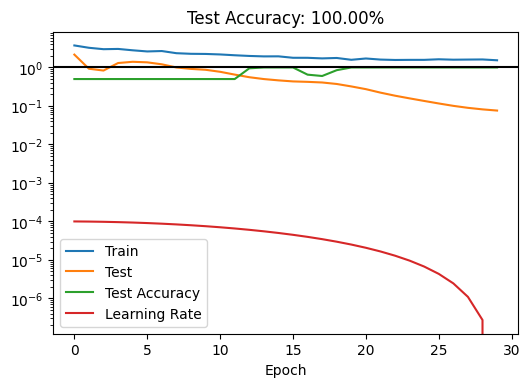

In [5]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots( dpi = 100, figsize = ( 6.0, 4.0 ) )
ax.plot( train_loss, label = 'Train' )
ax.plot( test_loss, label = 'Test' )
ax.plot( test_accuracy, label = 'Test Accuracy' )
ax.plot( lr, label = 'Learning Rate' )
ax.legend()
ax.set_yscale( 'log' )
ax.set_xlabel( 'Epoch' )
ax.axhline( 1, color = 'k' )
ax.set_title( acc_str )

# out_train = input_dir / f'{tag}_train.png'
# fig.savefig( out_train )

In [6]:
net.model.eval()

output = [ 
    ( net.model( test_feats.to( net._device ) ).cpu().argmax( axis = 1 ), test_labels )
    for test_feats, test_labels 
    in DataLoader( test_dset, batch_size = batch_size ) 
]

decode, test_y = zip( *output )
test_y = torch.cat( test_y, axis = 0 )
decode = torch.cat( decode, axis = 0 )

classes = list( sorted( test_dset.label_map.values() ) ) 
rev_dict = { v: k for k, v in test_dset.label_map.items() }
class_labels = [ rev_dict[ c ] for c in classes ]
confusion = np.zeros( ( len( classes ), len( classes ) ) )
for true_idx, true_class in enumerate( classes ):
    class_trials = np.where( test_y == true_class )[0]
    for pred_idx, pred_class in enumerate( classes ):
        num_preds = ( decode[ class_trials ] == pred_class ).sum().item()
        confusion[ true_idx, pred_idx ] = num_preds / len( class_trials )


fig, ax = plt.subplots( dpi = 100 )
corners = np.arange( len( classes ) + 1 ) - 0.5
im = ax.pcolormesh( 
    corners, corners, confusion, alpha = 0.5,
    cmap = plt.cm.Blues, vmin = 0.0, vmax = 1.0
)

for row_idx, row in enumerate( confusion ):
    for col_idx, freq in enumerate( row ):
        ax.annotate( 
            f'{freq:0.2f}', ( col_idx, row_idx ), 
            ha = 'center', va = 'center' 
        )

ax.set_aspect( 'equal' )
ax.set_xticks( classes )
ax.set_yticks( classes )
ax.set_xticklabels( class_labels )
ax.set_yticklabels( class_labels )
ax.set_ylabel( 'True Class' )
ax.set_xlabel( 'Predicted Class' )
ax.invert_yaxis( )
fig.colorbar( im )
ax.set_title( acc_str )


AttributeError: 'FBCSPDataset' object has no attribute 'label_dict'

In [ ]:
checkpoint = {
    'model_definition': model_definition,
    'fs': trials.fs, 
    'model_state_dict': model.state_dict(),
    'optimizer_state_dict': optimizer.state_dict(),
}

out_checkpoint = f'FBCSP.checkpoint'
torch.save( checkpoint, out_checkpoint )